In [1]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [3]:
ids = Test_data['building_id']

Train_data = Train_data.drop(['building_id'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

In [4]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
def na_check2(df_data):
    #missing data
    total = df_data.isnull().sum().sort_values(ascending=False)
    percent = (df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data.head(4))
    
def area_type(row):
    if row >= 0:
        return 1
    else:
        return 0
    
def house_type(row):
    if row == 0:
        return 0
    else:
        return 1

In [5]:
na_check(Train_data)
na_check(Test_data)

,Missing Ratio
parking_area,94.828333
parking_price,76.775000
txn_floor,26.503333
village_income_median,1.903333


,Missing Ratio
parking_area,95.00
parking_price,77.10
txn_floor,26.39
village_income_median,1.84


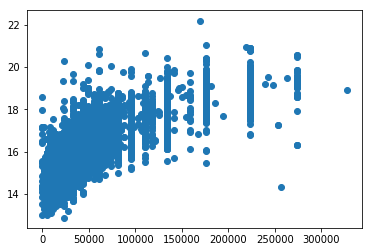

In [6]:
Train_data.sort_values(by = 'parking_price', ascending = False)[:4]
Train_data = Train_data.drop(55472)
Train_data = Train_data.drop(8795)
Train_data = Train_data.drop(37480)
Train_data = Train_data.drop(51731)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["parking_price"], train_Y)

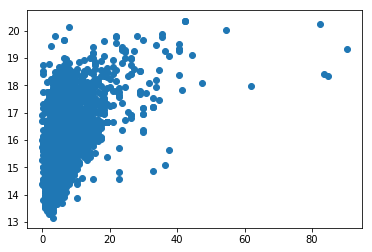

In [7]:
Train_data.sort_values(by = 'parking_area', ascending = False)[:2]
Train_data = Train_data.drop(38617)
Train_data = Train_data.drop(41914)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data
plt.scatter(train_X["parking_area"], train_Y)

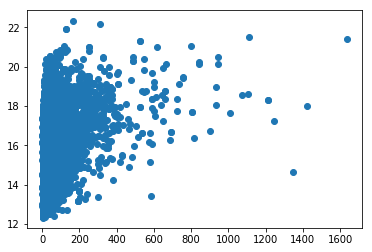

In [8]:
Train_data.sort_values(by = 'land_area', ascending = False)[:10]
Train_data = Train_data.drop(10670)
Train_data = Train_data.drop(41331)
Train_data = Train_data.drop(39191)
Train_data = Train_data.drop(53966)
Train_data = Train_data.drop(7814)
Train_data = Train_data.drop(13332)
Train_data = Train_data.drop(9785)
Train_data = Train_data.drop(14007)
Train_data = Train_data.drop(50076)
Train_data = Train_data.drop(2086)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["land_area"], train_Y)

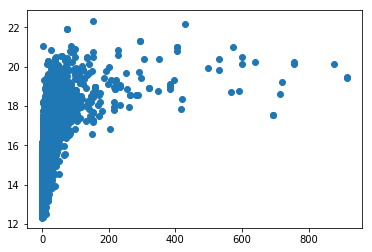

In [9]:
Train_data.sort_values(by = 'building_area', ascending = False)[:20]
Train_data = Train_data.drop(9491)
Train_data = Train_data.drop(46934)

train_Y = np.log1p(Train_data['total_price'])
train_X = Train_data

plt.scatter(train_X["building_area"], train_Y)

In [10]:
Train_data = Train_data.drop(['total_price'] , axis=1)

df = pd.concat([Train_data,Test_data])
df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,NaN,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,NaN,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,NaN,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,NaN,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [11]:
train_num = train_Y.shape[0]

df['txn_floor'] = df['txn_floor'].fillna(0)
df["house_type"] = df['txn_floor'].apply(house_type)

In [12]:
parking_price = df['parking_price']
parking_area = df['parking_area']

df = df.drop(['parking_price'] , axis=1)
df = df.drop(['parking_area'] , axis=1)

df = df.fillna(df.mean())
df['parking_price'] = parking_price
df['parking_area'] = parking_area

In [13]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = np.log1p(park_not_null['parking_price'])

XGB = xgb.XGBRegressor()
XGB.fit(park_X, park_Y)

park_pred = XGB.predict(park_is_null)
df.loc[df['parking_price'].notnull(), 'parking_price'] = np.log1p(park_not_null['parking_price'])
df.loc[df['parking_price'].isnull(), 'parking_price'] = park_pred

df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,house_type,parking_price,parking_area
0,8,21,18674,4,3,2,6271,2,3.0,18.144460,...,157,1,2483,1,6011,1,34.469803,1,4.767733,NaN
1,8,7,18800,5,1,2,7885,2,5.0,11.387227,...,115,1,15872,1,32221,1,40.073573,1,10.467614,NaN
2,8,7,19289,4,1,2,6028,2,1.0,21.426802,...,212,1,15760,1,32228,1,54.462081,1,10.470910,NaN
3,8,21,20385,24,0,2,18325,0,13.0,11.387227,...,125,1,2568,1,7271,1,99.628966,1,11.303930,NaN
4,1,21,20657,2,4,2,6880,2,0.0,61.306524,...,47,1,2587,1,7442,1,124.131236,0,8.213461,NaN


In [14]:
park_area_not_null = df[df['parking_area'].notnull()]
park_area_is_null = df[df['parking_area'].isnull()].drop(['parking_area'] , axis=1)

park_area_X = park_area_not_null.drop(['parking_area'] , axis=1)
park_area_Y = park_area_not_null['parking_area']

XGBR = xgb.XGBRegressor()
XGBR.fit(park_area_X, park_area_Y)

park_area_pred = XGBR.predict(park_area_is_null)

df.loc[df['parking_area'].isnull(), 'parking_area'] = park_area_pred

df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,house_type,parking_price,parking_area
0,8,21,18674,4,3,2,6271,2,3.0,18.144460,...,157,1,2483,1,6011,1,34.469803,1,4.767733,4.413631
1,8,7,18800,5,1,2,7885,2,5.0,11.387227,...,115,1,15872,1,32221,1,40.073573,1,10.467614,2.755655
2,8,7,19289,4,1,2,6028,2,1.0,21.426802,...,212,1,15760,1,32228,1,54.462081,1,10.470910,2.166138
3,8,21,20385,24,0,2,18325,0,13.0,11.387227,...,125,1,2568,1,7271,1,99.628966,1,11.303930,6.255847
4,1,21,20657,2,4,2,6880,2,0.0,61.306524,...,47,1,2587,1,7442,1,124.131236,0,8.213461,0.287667


In [161]:
temp_df = copy.deepcopy(df)

In [146]:
temp_df = temp_df.fillna(temp_df.mean())

temp_df["parking_price"] = temp_df["parking_price"].clip(0.1, temp_df["parking_price"].max())
temp_df["parking_area"] = temp_df["parking_area"].clip(0.1, temp_df["parking_area"].max())

temp_df["txn_dt"] = temp_df["txn_dt"]/100
temp_df["building_complete_dt"] = temp_df["building_complete_dt"]/100

temp_df["village_income_median"] = np.log1p(temp_df["village_income_median"])

temp_df["town_area"] = temp_df["town_area"].clip(1, 150)

temp_df["total_building_area"] = temp_df["building_area"] * temp_df["total_floor"]
temp_df["total_income"] = np.log1p(temp_df["village_income_median"] * temp_df["town_population"])
temp_df["area_percent"] = temp_df["land_area"] / temp_df["town_area"]
temp_df["per_parking_price"] = np.log1p(np.expm1(temp_df["parking_price"]) / temp_df["parking_area"])

temp_df["area_diff"] = temp_df["land_area"] - temp_df["building_area"]
temp_df['area_type'] = temp_df['area_diff'].apply(area_type)
#temp_df = temp_df.drop(['area_diff'] , axis=1)

temp_df = temp_df.fillna(temp_df.mean())

train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [129]:
temp_df["txn_floor"] = temp_df["txn_floor"].astype('int')

cols = ["city", "building_type", "building_use", "total_floor", "txn_floor", "building_material", "parking_way"]

for c in cols:
    mean_df = df.groupby([c])['parking_price'].mean().reset_index()
    mode_df = df.groupby([c])['parking_price'].apply(lambda x: x.mode()[0]).reset_index()
    median_df = df.groupby([c])['parking_price'].median().reset_index()
    max_df = df.groupby([c])['parking_price'].max().reset_index()
    temp = pd.merge(mean_df, mode_df, how='left', on=[c])
    temp = pd.merge(temp, median_df, how='left', on=[c])
    temp = pd.merge(temp, max_df, how='left', on=[c])
    temp.columns = [c, f'{c}_Mean', f'{c}_Mode', f'{c}_Median', f'{c}_Max']
    
    temp_df = pd.merge(temp_df, temp, how='left', on=[c])
    temp_df = temp_df.drop([c] , axis=1)
    
temp_df.head()

,txn_dt,building_complete_dt,land_area,building_area,town,lat,lon,village_income_median,town_population,town_area,...,txn_floor_Median,txn_floor_Max,building_material_Mean,building_material_Mode,building_material_Median,building_material_Max,parking_way_Mean,parking_way_Mode,parking_way_Median,parking_way_Max
0,186.74,62.71,18.144460,3.418175,334,-39.14,117.08,6.350886,24219.0,1.4161,...,10.389216,12.518452,9.957378,10.409924,10.086008,12.697599,9.691088,10.083982,9.580376,11.594179
1,188.00,78.85,11.387227,4.041309,180,-37.66,119.28,6.311735,551480.0,23.1373,...,10.335357,12.697599,9.957378,10.409924,10.086008,12.697599,9.691088,10.083982,9.580376,11.594179
2,192.89,60.28,21.426802,5.584279,180,-37.67,119.29,6.439350,551480.0,23.1373,...,10.363612,12.518452,9.957378,10.409924,10.086008,12.697599,9.691088,10.083982,9.580376,11.594179
3,203.85,183.25,11.387227,13.563031,343,-39.13,117.09,6.857514,139259.0,14.7523,...,10.554887,12.315351,9.957378,10.409924,10.086008,12.697599,10.724095,10.409924,10.687228,12.697599
4,206.57,68.80,61.306524,4.688108,102,-39.24,117.19,6.285998,112397.0,71.0400,...,9.042790,11.803580,9.321429,10.393011,9.070438,11.419501,9.691088,10.083982,9.580376,11.594179


In [162]:
temp_df = temp_df.drop(['doc_rate', 'master_rate', 'jobschool_rate', 'highschool_rate'] , axis=1)
temp_df = temp_df.drop(['XIII_5000'] , axis=1)

temp_df = temp_df.drop(['town'] , axis=1)
temp_df = temp_df.drop(['village'] , axis=1)

In [163]:
data = pd.concat([temp_df[:train_num], train_Y], axis=1)
test_data = temp_df[train_num:]

temp_df["txn_floor"] = temp_df["txn_floor"].astype('int')

cols = ["city", "building_type", "building_use", "total_floor", "txn_floor"]

for c in cols:
    
    mean_df = data.groupby([c])['total_price'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    
    data = pd.merge(data, mean_df, on= c, how='left')
    data = data.drop([c] , axis=1)
    
    test_data = pd.merge(test_data, mean_df, on= c, how='left')   
    test_data = test_data.drop([c] , axis=1)
    
data = data.drop(['total_price'] , axis=1)

In [164]:
temp_df = pd.concat([data,test_data])
temp_df.head()

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,lat,lon,village_income_median,town_population,...,XIV_index_10000,XIV_MIN,house_type,parking_price,parking_area,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,18674,6271,2,18.144460,3.418175,-39.14,117.08,572.0,24219.0,...,1,34.469803,1,4.767733,4.413631,14.761401,15.617864,15.49522,15.607523,15.427335
1,8,18800,7885,2,11.387227,4.041309,-37.66,119.28,550.0,551480.0,...,1,40.073573,1,10.467614,2.755655,15.732706,15.368477,15.49522,15.398017,15.359153
2,8,19289,6028,2,21.426802,5.584279,-37.67,119.29,625.0,551480.0,...,1,54.462081,1,10.470910,2.166138,15.732706,15.368477,15.49522,15.607523,15.784832
3,8,20385,18325,0,11.387227,13.563031,-39.13,117.09,950.0,139259.0,...,1,99.628966,1,11.303930,6.255847,14.761401,15.837045,15.49522,16.127585,15.832799
4,1,20657,6880,2,61.306524,4.688108,-39.24,117.19,536.0,112397.0,...,1,124.131236,0,8.213461,0.287667,14.761401,15.426263,15.49522,14.951800,15.426263


In [73]:
temp_df['I_10000'] = temp_df['I_10000'].astype(int)
temp_df['I_10000_'] = pd.qcut(temp_df['I_10000'], 5)
temp_df['I_10000_'].unique()

[(565.0, 891.0], (891.0, 1456.0], (355.0, 565.0], (1456.0, 1783.0], (14.999, 355.0]]
Categories (5, interval[float64]): [(14.999, 355.0] < (355.0, 565.0] < (565.0, 891.0] < (891.0, 1456.0] < (1456.0, 1783.0]]

In [85]:
temp_df.loc[temp_df['I_10000']<=355.0, 'I_10000'] = 1
temp_df.loc[(temp_df['I_10000']>355.0) & (temp_df['I_10000']<=565.0), 'I_10000'] = 2
temp_df.loc[(temp_df['I_10000']>565.0) & (temp_df['I_10000']<=891.0), 'I_10000'] = 3
temp_df.loc[(temp_df['I_10000']>891.0) & (temp_df['I_10000']<=1456.0), 'I_10000'] = 4
temp_df.loc[temp_df['I_10000']>1456.0, 'I_10000'] = 5
temp_df['I_10000'] = temp_df['I_10000'].astype(int)

temp_df.drop('I_10000_', axis=1, inplace=True)
temp_df.head(3)

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,lat,lon,village_income_median,town_population,...,total_income,area_percent,per_parking_price,area_diff,area_type,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,186.74,62.71,2,18.144460,3.418175,-39.14,117.08,6.350886,24219.0,...,11.943494,12.812980,3.311636,14.726285,1,14.761401,15.617864,15.49522,15.607523,15.427335
1,8,188.00,78.85,2,11.387227,4.041309,-37.66,119.28,6.311735,551480.0,...,15.062772,0.492159,9.454009,7.345919,1,15.732706,15.368477,15.49522,15.398017,15.359153
2,8,192.89,60.28,2,21.426802,5.584279,-37.67,119.29,6.439350,551480.0,...,15.082789,0.926072,9.697997,15.842523,1,15.732706,15.368477,15.49522,15.607523,15.784832


In [88]:
temp_df['II_10000'] = temp_df['II_10000'].astype(int)
temp_df['II_10000_'] = pd.qcut(temp_df['II_10000'], 5)
temp_df['II_10000_'].unique()

[(1403.0, 2113.0], (3064.0, 5020.0], (11.999, 1403.0], (2113.0, 3064.0], (5020.0, 6408.0]]
Categories (5, interval[float64]): [(11.999, 1403.0] < (1403.0, 2113.0] < (2113.0, 3064.0] < (3064.0, 5020.0] < (5020.0, 6408.0]]

In [91]:
temp_df.loc[temp_df['II_10000']<=1403.0, 'II_10000'] = 1
temp_df.loc[(temp_df['II_10000']>1403.0) & (temp_df['II_10000']<=2113.0), 'II_10000'] = 2
temp_df.loc[(temp_df['II_10000']>2113.0) & (temp_df['II_10000']<=3064.0), 'II_10000'] = 3
temp_df.loc[(temp_df['II_10000']>3064.0) & (temp_df['II_10000']<=5020.0), 'II_10000'] = 4
temp_df.loc[temp_df['II_10000']>5020.0, 'II_10000'] = 5
temp_df['II_10000'] = temp_df['II_10000'].astype(int)

temp_df.drop('II_10000_', axis=1, inplace=True)
temp_df.head(3)

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,lat,lon,village_income_median,town_population,...,total_income,area_percent,per_parking_price,area_diff,area_type,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,186.74,62.71,2,18.144460,3.418175,-39.14,117.08,6.350886,24219.0,...,11.943494,12.812980,3.311636,14.726285,1,14.761401,15.617864,15.49522,15.607523,15.427335
1,8,188.00,78.85,2,11.387227,4.041309,-37.66,119.28,6.311735,551480.0,...,15.062772,0.492159,9.454009,7.345919,1,15.732706,15.368477,15.49522,15.398017,15.359153
2,8,192.89,60.28,2,21.426802,5.584279,-37.67,119.29,6.439350,551480.0,...,15.082789,0.926072,9.697997,15.842523,1,15.732706,15.368477,15.49522,15.607523,15.784832


In [93]:
temp_df['III_10000'] = temp_df['III_10000'].astype(int)
temp_df['III_10000_'] = pd.qcut(temp_df['III_10000'], 5)
temp_df['III_10000_'].unique()

[(2090.0, 3804.0], (4988.0, 9217.0], (3804.0, 4988.0], (4.999, 2090.0], (9217.0, 11478.0]]
Categories (5, interval[float64]): [(4.999, 2090.0] < (2090.0, 3804.0] < (3804.0, 4988.0] < (4988.0, 9217.0] < (9217.0, 11478.0]]

In [94]:
temp_df.loc[temp_df['III_10000']<=2090.0, 'III_10000'] = 1
temp_df.loc[(temp_df['III_10000']>2090.0) & (temp_df['III_10000']<=3804.0), 'III_10000'] = 2
temp_df.loc[(temp_df['III_10000']>3804.0) & (temp_df['III_10000']<=4988.0), 'III_10000'] = 3
temp_df.loc[(temp_df['III_10000']>4988.0) & (temp_df['III_10000']<=9217.0), 'III_10000'] = 4
temp_df.loc[temp_df['III_10000']>9217.0, 'III_10000'] = 5
temp_df['III_10000'] = temp_df['III_10000'].astype(int)

temp_df.drop('III_10000_', axis=1, inplace=True)
temp_df.head(3)

,building_material,txn_dt,building_complete_dt,parking_way,land_area,building_area,lat,lon,village_income_median,town_population,...,total_income,area_percent,per_parking_price,area_diff,area_type,city_mean,building_type_mean,building_use_mean,total_floor_mean,txn_floor_mean
0,8,186.74,62.71,2,18.144460,3.418175,-39.14,117.08,6.350886,24219.0,...,11.943494,12.812980,3.311636,14.726285,1,14.761401,15.617864,15.49522,15.607523,15.427335
1,8,188.00,78.85,2,11.387227,4.041309,-37.66,119.28,6.311735,551480.0,...,15.062772,0.492159,9.454009,7.345919,1,15.732706,15.368477,15.49522,15.398017,15.359153
2,8,192.89,60.28,2,21.426802,5.584279,-37.67,119.29,6.439350,551480.0,...,15.082789,0.926072,9.697997,15.842523,1,15.732706,15.368477,15.49522,15.607523,15.784832


In [165]:
train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

In [166]:
temp_train = copy.deepcopy(train_X)
temp_train["total_price"] = train_Y

In [167]:
corr = temp_train.corr()["total_price"]
high_feature = corr[abs(corr) >= 0.001]
high_feature.sort_values(ascending=False)

total_price              1.000000
parking_price            0.020430
city_mean                0.020142
XIII_10000               0.019772
VII_10000                0.019613
V_10000                  0.019388
IX_10000                 0.019335
VI_10000                 0.019186
VIII_10000               0.018854
X_10000                  0.018693
III_10000                0.018586
XII_10000                0.018264
IV_10000                 0.018223
II_10000                 0.017994
XI_10000                 0.017861
I_10000                  0.017187
II_1000                  0.015958
V_5000                   0.015923
bachelor_rate            0.015839
VII_5000                 0.015657
XII_5000                 0.015443
lon                      0.015416
II_5000                  0.015243
VIII_5000                0.015094
II_500                   0.014929
III_5000                 0.014922
village_income_median    0.014676
X_5000                   0.014621
V_10                     0.014540
IX_5000       

In [168]:
high_feature = list(high_feature.index)
high_feature

['building_material',
 'txn_dt',
 'building_complete_dt',
 'parking_way',
 'land_area',
 'building_area',
 'lat',
 'lon',
 'village_income_median',
 'town_population',
 'town_area',
 'town_population_density',
 'bachelor_rate',
 'junior_rate',
 'elementary_rate',
 'born_rate',
 'death_rate',
 'marriage_rate',
 'divorce_rate',
 'N_50',
 'N_500',
 'N_1000',
 'N_5000',
 'I_10',
 'I_50',
 'I_index_50',
 'I_100',
 'I_250',
 'I_500',
 'I_1000',
 'I_5000',
 'I_10000',
 'I_MIN',
 'II_10',
 'II_50',
 'II_index_50',
 'II_100',
 'II_250',
 'II_500',
 'II_index_500',
 'II_1000',
 'II_index_1000',
 'II_5000',
 'II_10000',
 'II_MIN',
 'III_10',
 'III_50',
 'III_index_50',
 'III_100',
 'III_250',
 'III_500',
 'III_index_500',
 'III_1000',
 'III_index_1000',
 'III_5000',
 'III_10000',
 'III_MIN',
 'IV_10',
 'IV_50',
 'IV_index_50',
 'IV_100',
 'IV_250',
 'IV_500',
 'IV_1000',
 'IV_index_1000',
 'IV_5000',
 'IV_10000',
 'IV_MIN',
 'V_10',
 'V_50',
 'V_index_50',
 'V_100',
 'V_250',
 'V_500',
 'V_index_

In [169]:
remove = []

for f in high_feature:
    if ("0" in f) and (f.split("_")[1] != "10000"):
        remove.append(f)
        
for f in remove:
    high_feature.remove(f)

In [170]:
high_feature.remove("total_price")
train_X = train_X[high_feature]
test_X = test_X[high_feature]

In [171]:
high_feature

['building_material',
 'txn_dt',
 'building_complete_dt',
 'parking_way',
 'land_area',
 'building_area',
 'lat',
 'lon',
 'village_income_median',
 'town_population',
 'town_area',
 'town_population_density',
 'bachelor_rate',
 'junior_rate',
 'elementary_rate',
 'born_rate',
 'death_rate',
 'marriage_rate',
 'divorce_rate',
 'I_10000',
 'I_MIN',
 'II_10000',
 'II_MIN',
 'III_10000',
 'III_MIN',
 'IV_10000',
 'IV_MIN',
 'V_10000',
 'V_MIN',
 'VI_10000',
 'VI_MIN',
 'VII_10000',
 'VII_MIN',
 'VIII_10000',
 'VIII_MIN',
 'IX_10000',
 'IX_MIN',
 'X_10000',
 'X_MIN',
 'XI_10000',
 'XI_MIN',
 'XII_10000',
 'XII_MIN',
 'XIII_10000',
 'XIII_MIN',
 'XIV_10000',
 'XIV_MIN',
 'house_type',
 'parking_price',
 'parking_area',
 'city_mean',
 'building_type_mean',
 'building_use_mean',
 'total_floor_mean',
 'txn_floor_mean']

In [172]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor()
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9399949353081134
Mean squared error: 0.0757


In [173]:
estimator_ = RandomForestRegressor(random_state=7)
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price
submit.to_csv("2019-07-06.csv",index=False)

/home/rex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


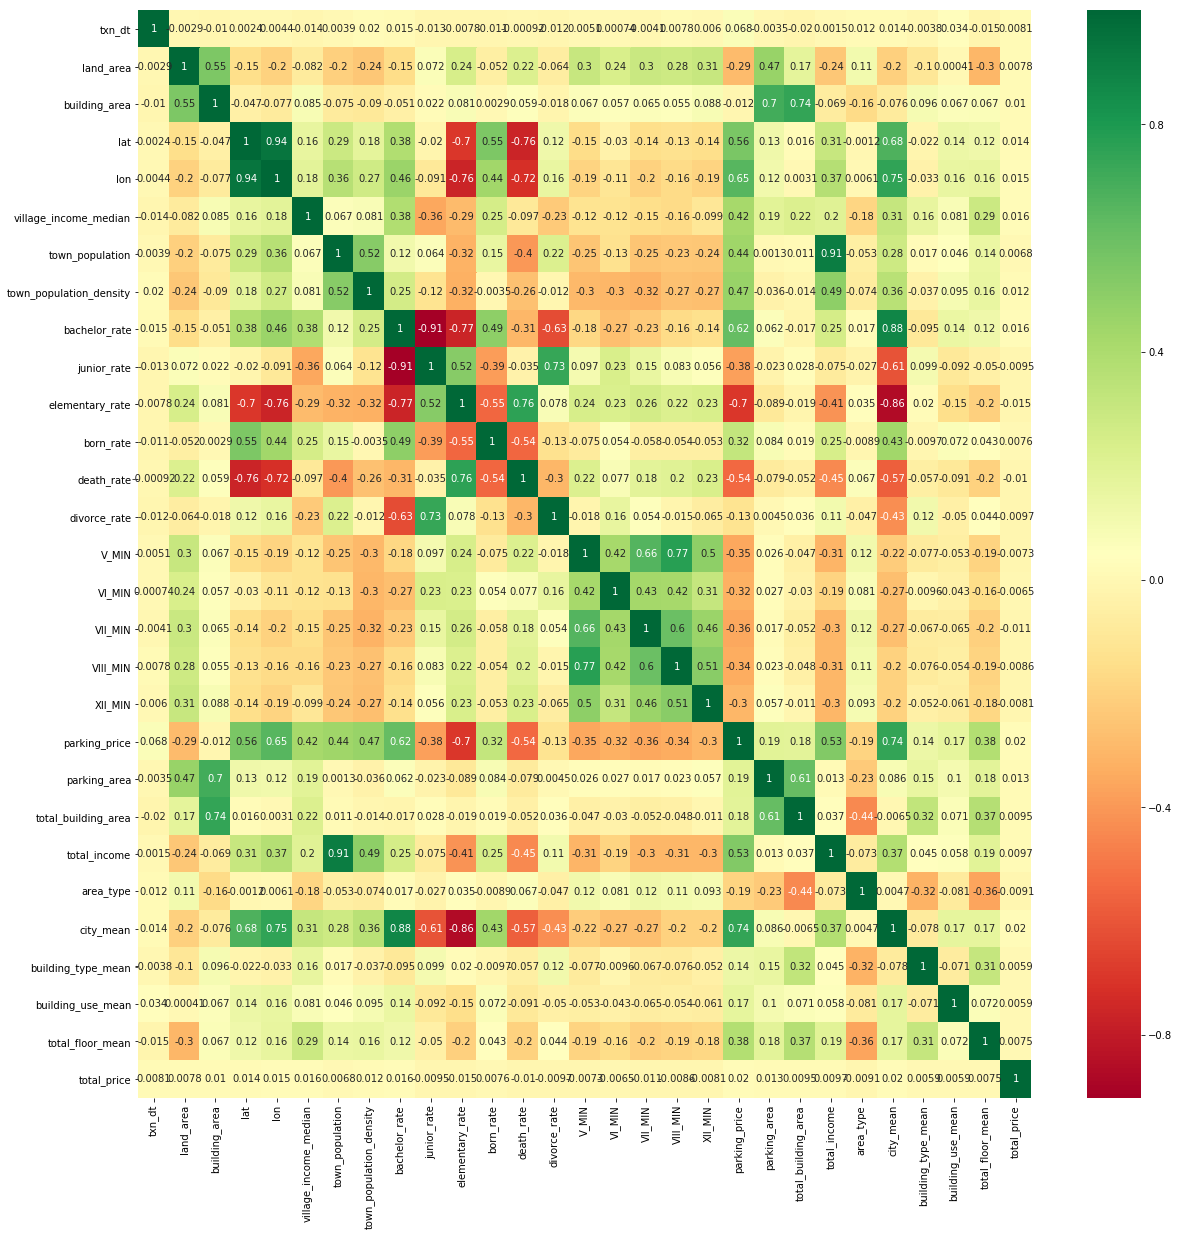

In [160]:
temp_train = copy.deepcopy(train_X)
temp_train["total_price"] = train_Y

corrmat = temp_train.corr()
top_corr_features = corrmat.index[abs(corrmat["total_price"])>0.005]
plt.figure(figsize=(20,20))
g = sns.heatmap(temp_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [174]:
train_X.columns

Index(['building_material', 'txn_dt', 'building_complete_dt', 'parking_way',
       'land_area', 'building_area', 'lat', 'lon', 'village_income_median',
       'town_population', 'town_area', 'town_population_density',
       'bachelor_rate', 'junior_rate', 'elementary_rate', 'born_rate',
       'death_rate', 'marriage_rate', 'divorce_rate', 'I_10000', 'I_MIN',
       'II_10000', 'II_MIN', 'III_10000', 'III_MIN', 'IV_10000', 'IV_MIN',
       'V_10000', 'V_MIN', 'VI_10000', 'VI_MIN', 'VII_10000', 'VII_MIN',
       'VIII_10000', 'VIII_MIN', 'IX_10000', 'IX_MIN', 'X_10000', 'X_MIN',
       'XI_10000', 'XI_MIN', 'XII_10000', 'XII_MIN', 'XIII_10000', 'XIII_MIN',
       'XIV_10000', 'XIV_MIN', 'house_type', 'parking_price', 'parking_area',
       'city_mean', 'building_type_mean', 'building_use_mean',
       'total_floor_mean', 'txn_floor_mean'],
      dtype='object')